In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import copy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np

## real samples falling in this region

In [2]:
# selected AOI
a50 = gpd.read_file('./material/eg_agg_50km.gpkg')
# a50 = a50.rename(columns={'id':'grid_id'})
a100 = gpd.read_file('./material/eg_agg_100km.gpkg')
a200 = gpd.read_file('./material/eg_agg_200km.gpkg')

ag = pd.concat([a50, a100, a200])
ag = ag.reset_index(drop=True)
# ag.to_crs("EPSG:4326")

# read in the sampled data
df = pd.read_parquet('./material/soc.topsoil_organized.pq')
df = df.loc[df['ref'] == 'LUCAS']
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
df = df.to_crs(ag.crs)

In [3]:
aggregated_stats = pd.read_parquet('./material/snr.agg_measurement.aggregated_v20250301.pq')

# # join
# sdf = gpd.sjoin(df, ag, how="inner", predicate="within")
# sdf = sdf.rename(columns={'id_right':'polygon_id','id_left':'id','nuts0_left':'nuts0','nuts0_right':'region'})
# sdf = sdf.drop(columns=['index_right'])
# sdf['agg_id'] = sdf['nuts0'].astype(str) + '-' + sdf['polygon_id'].astype(str)

# # sdf.loc[(sdf['polygon_id']==94) & (sdf['time']==2015), ['lc_survey','soc']]

# sdf['ndvi'] = sdf['ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127']
# sdf['ndwi'] = sdf['ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218']

# p = ['ndvi','ndwi','soc']

# aggregated_stats = sdf.groupby(['scale', 'polygon_id', 'region', 'time'])[p].describe()
# aggregated_stats.columns = ['_'.join(col).strip() for col in aggregated_stats.columns.values]
# aggregated_stats = aggregated_stats.reset_index()

# aggregated_stats = aggregated_stats.loc[aggregated_stats['time'].isin([2009,2015,2018])]

# aggregated_stats.to_parquet('./material/snr.agg_measurement.aggregated_v20250301.pq')

## model predictions

In [4]:
pnt_dfp_df = pd.read_parquet('./material/snr.agg_pred_v20250301.pq')

In [4]:
# load and train the model

prop = 'soc'
tgt = 'soc_log1p'
version = 'v20250301'

covs = pd.read_csv(f'./metric/feature_selected_soc_{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.soc_ccc_{version}.joblib')
model.n_jobs = 90

df[tgt] = np.log1p(df[prop])
df = df.dropna(subset=covs+[tgt],how='any')
model.fit(df[covs],df[tgt])

from trees_rf import cast_tree_rf, cast_node_rf, pad_leaf_outputs_to_array
import warnings
warnings.filterwarnings("ignore", message="X has feature names, but")

ttprint('casting node model')
df = df.reset_index(drop=True)
model_copy = copy.deepcopy(model)
modeln = cast_node_rf(model_copy, df[covs], df[tgt])
ttprint('finish model casting')

# read in the sampled points for prediciton
dfp = pd.read_parquet('./material/snr.agg_overlaid_v20250301.pq')
print(dfp.shape)
dfp = dfp.dropna(subset=covs,how='any')
print(dfp.shape)
# convert to gpd
geometry = [Point(xy) for xy in zip(dfp['lon'], dfp['lat'])]
dfp = gpd.GeoDataFrame(dfp, geometry=geometry, crs=ag.crs)
# dfp = dfp.to_crs()

[08:26:04] casting node model
[08:26:23] finish model casting
(300000, 251)
(299389, 251)


In [9]:
## aggregate to regional
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
pnt_dfp = []
for gid in dfp['grid_id'].unique():
    for ty in [2009, 2015, 2018]:
        # df in each sample block
        bdf = dfp.loc[(dfp['grid_id']==gid) & (dfp['time']==ty)]
        # uncertainty
        ttprint(f'start predicting for year {ty}, grid {gid}, {bdf.shape}')
        leaf_outputs = modeln.predict(bdf[covs])
        nodes = pad_leaf_outputs_to_array(leaf_outputs, pad_value=np.nan)
        nodes = nodes.T
        ttprint('finish node predictions, ', nodes.shape)
        nodes = np.expm1(nodes)
        bdf['pred_std'] = np.nanstd(nodes, axis=0)
        # predictions
        bdf['soc_pred'] = np.expm1(model.predict(bdf[covs]))
        
        pnt_dfp.append(bdf)
        
pnt_dfp_df = pd.concat(pnt_dfp)
pnt_dfp_df.to_parquet('./material/snr.agg_pred_v20250301.pq')

[12:43:21] start predicting for year 2009, grid 47, (9992, 252)
[12:44:51] finish node predictions,  (6207, 9992)
[12:44:52] start predicting for year 2015, grid 47, (9989, 252)
[12:46:22] finish node predictions,  (5502, 9989)
[12:46:23] start predicting for year 2018, grid 47, (9992, 252)
[12:47:54] finish node predictions,  (5674, 9992)
[12:47:54] start predicting for year 2009, grid 94, (9992, 252)
[12:49:25] finish node predictions,  (17338, 9992)
[12:49:28] start predicting for year 2015, grid 94, (9992, 252)
[12:50:58] finish node predictions,  (15214, 9992)
[12:51:00] start predicting for year 2018, grid 94, (9992, 252)
[12:52:32] finish node predictions,  (18047, 9992)
[12:52:34] start predicting for year 2009, grid 577, (9991, 252)
[12:54:13] finish node predictions,  (28917, 9991)
[12:54:16] start predicting for year 2015, grid 577, (9991, 252)
[12:55:54] finish node predictions,  (28508, 9991)
[12:55:58] start predicting for year 2018, grid 577, (9991, 252)
[12:57:33] finis

AttributeError: 'GeoDataFrame' object has no attribute 'concat'

In [5]:
from model_fit import spherical_model, exponential_model, gaussian_model

def correlation_function(h, theory_model, nugget, sill, range_):
    # Calculate the variogram value at distance h
    if theory_model == 'exponential':
        gamma_h = exponential_model(h, nugget, sill, range_)
    elif theory_model == 'spherical':
        gamma_h = spherical_model(h, nugget, sill, range_)
    elif theory_model == 'gaussian':
        gamma_h = gaussian_model(h, nugget, sill, range_)
        
    # Calculate and return the correlation function value
    return (sill - gamma_h) / sill

params_es = ['gaussian', 0.71169539, 1.02002153, 59.24003943]
params_de = ['gaussian', 1.15621855e-19, 9.57961240e-01, 5.25958230e+00]

In [6]:
from scipy.spatial.distance import pdist, squareform
agg_var = []
agg_mean = []
agg_ndvi = []
agg_ndwi = []
agg_id = []
agg_reg = []
agg_scale = []
agg_time = []

for grid, time in pnt_dfp_df[['grid_id', 'time']].drop_duplicates().itertuples(index=False):
    idf = pnt_dfp_df[(pnt_dfp_df['grid_id'] == grid) & (pnt_dfp_df['time'] == time)]
    ttprint(grid)
    geometry = [Point(xy) for xy in zip(idf['lon'], idf['lat'])]
    idf = gpd.GeoDataFrame(idf, geometry=geometry, crs=ag.crs)
    coords = np.array([[geom.x, geom.y] for geom in idf.geometry])
    stds = idf['pred_std'].values
    n = len(stds)
    inut = idf.iloc[0]['nuts0']
    agg_id.append(grid)
    agg_reg.append(idf.iloc[0]['nuts0'])
    agg_scale.append(idf.iloc[0]['scale'])
    agg_time.append(time)

    # 1. Compute pairwise distances (upper triangle)
    dists = pdist(coords) / 1000  # km
    iu = np.triu_indices(n, k=1)  # indices for upper triangle (excluding diagonal)

    # 2. Compute correlations
    if inut == 'DE':
        rho_vals = correlation_function(dists, *params_de)
    elif inut == 'ES':
        rho_vals = correlation_function(dists, *params_es)

    # 3. Get stds for each pair
    std_matrix = np.outer(stds, stds)  # all std1 * std2
    std1_vals = std_matrix[iu]
    std2_vals = std_matrix[iu]  # same as std1_vals, since outer product is symmetric

    # 4. Covariance contributions
    cov_vals = rho_vals * std1_vals

    # 5. Add diagonal (variance) terms
    diag_cov = stds ** 2

    total_cov = np.sum(cov_vals) * 2 + np.sum(diag_cov)
    agg_var.append(total_cov / n**2)
    agg_mean.append(idf['soc_pred'].mean())
    agg_ndvi.append(idf['ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127'].mean())
    agg_ndwi.append(idf['ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218'].mean())

[11:35:43] 47
[11:35:47] 47
[11:35:51] 47
[11:35:55] 94
[11:36:00] 94
[11:36:04] 94
[11:36:08] 577
[11:36:12] 577
[11:36:16] 577
[11:36:20] 580
[11:36:24] 580
[11:36:28] 580
[11:36:32] 12
[11:36:36] 12
[11:36:40] 12
[11:36:44] 23
[11:36:48] 23
[11:36:51] 23
[11:36:55] 145
[11:36:59] 145
[11:37:03] 145
[11:37:07] 146
[11:37:11] 146
[11:37:15] 146
[11:37:19] 282
[11:37:23] 282
[11:37:26] 282
[11:37:30] 421
[11:37:34] 421
[11:37:39] 421


In [58]:
agg_pred = pd.DataFrame({
    'polygon_id': agg_id,
    'region': agg_reg,
    'time': agg_time,
    'scale': agg_scale,
    'soc_var': agg_var,
    'soc_mean': agg_mean,
    'ndvi_mean': agg_ndvi,
    'ndwi_mean': agg_ndwi
})
agg_pred['soc_std'] = np.sqrt(agg_pred['soc_var'])

In [59]:
agg_pred.to_parquet('./material/snr.agg_pred.aggregated_v20250301.pq')

### plot

In [7]:
agg_pred = pd.read_parquet('./material/snr.agg_pred.aggregated_v20250301.pq')
agg_mesr = pd.read_parquet('./material/snr.agg_measurement.aggregated_v20250301.pq')

agg_pred['ndvi_mean'] = (agg_pred['ndvi_mean']-125)/125
agg = agg_mesr.merge(agg_pred, how='left',on=['polygon_id','scale','region','time'])

rm_col = ['ndvi_count', 'ndvi_min', 'ndvi_25%', 'ndvi_50%', 'ndvi_75%', 'ndvi_max','ndwi_count', 'ndwi_min', 'ndwi_25%',
          'ndwi_50%', 'ndwi_75%', 'ndwi_max', 'soc_min', 'soc_25%', 'soc_50%', 'soc_75%', 'soc_max']
agg = agg.drop(columns=rm_col)

ES
Polygon: 47, Scale: 50
Polygon: 94, Scale: 50
Polygon: 12, Scale: 100
Polygon: 23, Scale: 100
Polygon: 282, Scale: 200


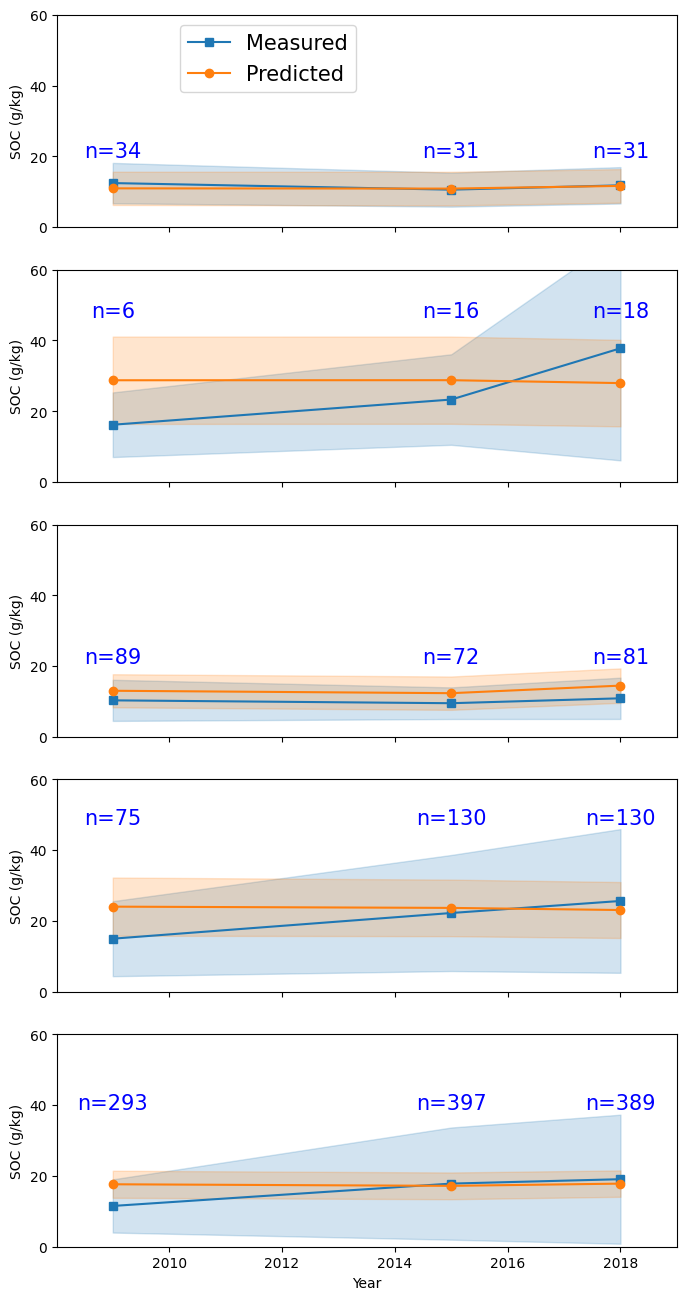

DE
Polygon: 577, Scale: 50
Polygon: 580, Scale: 50
Polygon: 145, Scale: 100
Polygon: 146, Scale: 100
Polygon: 421, Scale: 200


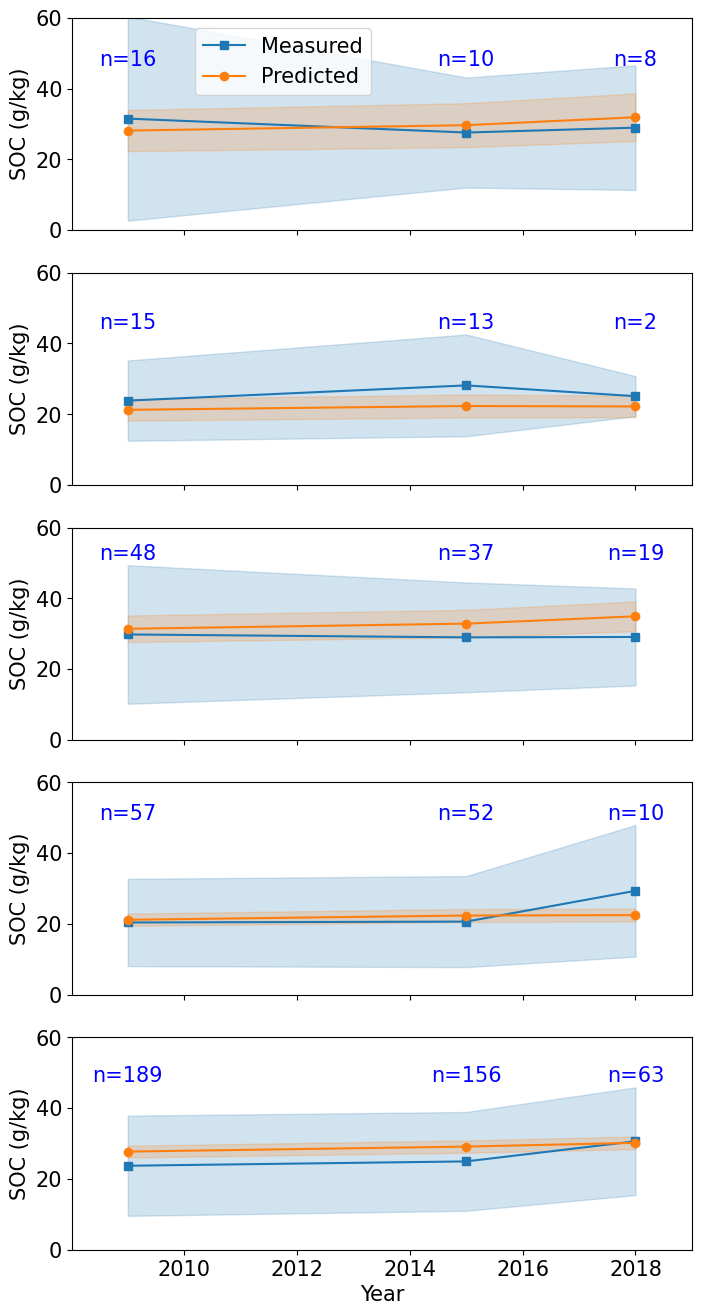

In [9]:
# time series plots
regions = agg_pred['region'].unique()

for region in regions:
    print(region)
    # Filter data for the region
    pred_region = agg_pred[agg_pred['region'] == region].sort_values('scale')
    mesr_region = agg_mesr[agg_mesr['region'] == region].sort_values('scale')

    # Get unique polygons (limit to 5)
    polygons = pred_region['polygon_id'].unique()

    # Create figure for the region
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 16), sharex=True)
    plt.rcParams.update({'font.size': 15})
    # fig.suptitle(f'From {region}', fontsize=16)

    for row_idx, polygon in enumerate(polygons):
        
        ax = axes[row_idx]

        # Filter by polygon
        pred_poly = pred_region[pred_region['polygon_id'] == polygon].sort_values('time')
        mesr_poly = mesr_region[mesr_region['polygon_id'] == polygon].sort_values('time')

        # Plot measured (first)
        if not mesr_poly.empty:
            ax.plot(mesr_poly['time'], mesr_poly['soc_mean'], '-s', label='Measured', color='tab:blue')
            ax.fill_between(mesr_poly['time'],
                            mesr_poly['soc_mean'] - mesr_poly['soc_std'],
                            mesr_poly['soc_mean'] + mesr_poly['soc_std'],
                            color='tab:blue', alpha=0.2)
            txt_max = max(mesr_poly['soc_mean'].max() + mesr_poly['soc_std'].max(),pred_poly['soc_mean'].max() + pred_poly['soc_std'].max())
            if txt_max>60:
                txt_max = 45
            for i, row in mesr_poly.iterrows():
                ax.text(row['time'], txt_max + 1.5,
                        'n='+str(int(row['soc_count'])), ha='center',color='blue') # fontsize=8, 

        # Plot predicted (second)
        if not pred_poly.empty:
            ax.plot(pred_poly['time'], pred_poly['soc_mean'], '-o', label='Predicted', color='tab:orange')
            ax.fill_between(pred_poly['time'],
                            pred_poly['soc_mean'] - pred_poly['soc_std'],
                            pred_poly['soc_mean'] + pred_poly['soc_std'],
                            color='tab:orange', alpha=0.2)
         
        # # Add second y-axis for NDVI
        # ax2 = ax.twinx()
        # if not pred_poly.empty:
        #     ax2.plot(pred_poly['time'], pred_poly['ndvi_mean'], '-^', label='NDVI', color='green')
        #     # ax2.fill_between(pred_poly['time'],
        #     #                  pred_poly['ndvi_mean'] - pred_poly['ndvi_std'],
        #     #                  pred_poly['ndvi_mean'] + pred_poly['ndvi_std'],
        #     #                  color='green', alpha=0.2)
        #     ax2.set_ylabel('NDVI', color='green')
        #     ax2.tick_params(axis='y', labelcolor='green')

        # Title with polygon and scale
        scale = pred_poly['scale'].iloc[0] if not pred_poly.empty else 'N/A'
        print(f'Polygon: {polygon}, Scale: {scale}')
        # ax.set_title(f'Polygon: {polygon}, Scale: {scale}', fontsize=10)
        ax.set_ylim([0,60])
        # ax2.set_ylim([0, 0.8])
        ax.set_xlim([2008.01,2019])

        if row_idx == 4:
            ax.set_xlabel('Year')
        ax.set_ylabel('SOC (g/kg)')
        if row_idx ==0:
            ax.legend(loc='upper right', bbox_to_anchor=(0.5, 1.0))

    # plt.tight_layout(rect=[0, 0, 1, 0.96])
    # plt.savefig(f'./figure/plot_agg_time.series.{region}.svg', bbox_inches='tight')
    plt.show()
    



In [10]:
# organize data pairs
from skmap.misc import TimeTracker, ttprint
import numpy as np
tcol = ['ndvi_mean_y','ndwi_mean_y', 'time', 'soc_mean_x','soc_mean_y', 'soc_std_x','soc_std_y'] # time series cols
scol = ['scale', 'polygon_id', 'region'] # static cols
mcol = ['ndvi_mean_y','ndwi_mean_y'] # cols that needs to take the average of the time series

ttprint('start organizing pairs')
agp_df = pd.DataFrame(columns=scol + [i+'_mean' for i in mcol] + [i+'_pair' for i in tcol])

for iid in agg['polygon_id'].unique():
    temp = agg.loc[agg['polygon_id'] == iid].sort_values(by=['time'])  
    
    # Extract static values (first row of static columns)
    static_vals = temp.iloc[0][scol].tolist()
        
    if len(temp) == 2:
        ts_vals = [temp[itcol].tolist() for itcol in tcol]
        mean_vals = [np.mean(il) for il in ts_vals[0:2]]
        agp_df.loc[len(agp_df)] = static_vals + mean_vals + ts_vals

    elif len(temp) > 2:
        # Case with 3 points: form 3 pairs
        ts_vals = [temp.iloc[[0, 1]][itcol].tolist() for itcol in tcol]
        mean_vals = [np.mean(il) for il in ts_vals[0:2]]
        agp_df.loc[len(agp_df)] = static_vals + mean_vals + ts_vals

        ts_vals = [temp.iloc[[1, 2]][itcol].tolist() for itcol in tcol]
        mean_vals = [np.mean(il) for il in ts_vals[0:2]]
        agp_df.loc[len(agp_df)] = static_vals + mean_vals + ts_vals

        ts_vals = [temp.iloc[[0, 2]][itcol].tolist() for itcol in tcol]
        mean_vals = [np.mean(il) for il in ts_vals[0:2]]
        agp_df.loc[len(agp_df)] = static_vals + mean_vals + ts_vals
    
ttprint('finish organizing')
print(agp_df.shape)

[11:42:50] start organizing pairs
[11:42:50] finish organizing
(30, 12)


In [11]:
# organize time series
tcol = ['time', 'soc_mean_x','soc_mean_y', 'soc_std_x','soc_std_y'] # time series cols
scol = ['scale', 'polygon_id', 'region'] # static cols
mcol = ['ndvi_mean_y','ndwi_mean_y'] # cols that needs to take the average of the time series

ttprint('start organizing series')
ags_df = pd.DataFrame(columns=scol + [i+'_mean' for i in mcol] + [i+'_series' for i in tcol])
for iid in agg['polygon_id'].unique():
    temp = agg.loc[agg['polygon_id'] == iid].sort_values(by=['time'])  
    
    # Extract static values (first row of static columns)
    static_vals = temp.iloc[0][scol].tolist()
    
    # Compute mean values for columns requiring averaging
    mean_vals = temp[mcol].mean().tolist()
    
    # Extract time series values as lists
    ts_vals = [temp[itcol].tolist() for itcol in tcol]
    
    # Concatenate all extracted values
    ags_df.loc[len(ags_df)] = static_vals + mean_vals + ts_vals
    
ttprint('finish organizing')
print(ags_df.shape)


[11:42:52] start organizing series
[11:42:52] finish organizing
(10, 10)


In [12]:
agp_df['$\delta'] = agp_df['soc_mean_x_pair'].str[1]-agp_df['soc_mean_x_pair'].str[0]
agp_df['noise'] = np.sqrt(agp_df['soc_std_y_pair'].str[1]**2+agp_df['soc_std_y_pair'].str[0]**2)
agp_df['signal'] = agp_df['$\delta'].abs()
agp_df['snr'] = agp_df['signal']/agp_df['noise']


In [13]:
agg['$c$'] = agg['soc_mean_x']
agg['noise'] = agg['soc_std_y']
agg['signal'] = agg['$c$'].abs()
agg['snr'] = agg['signal']/agg['noise']

In [14]:
from sklearn.linear_model import HuberRegressor, TheilSenRegressor

# tsdf = pd.read_csv('./material/soc_time.series_lucas.csv')
plzc = [] # two consecutive soc changes
tsr = TheilSenRegressor(random_state=42)
slope = [] # linear slope
intercept = [] # linear intercept
score = [] # R2 of predicted linear time series
std_slope_list = []

for index, row in ags_df.iterrows():
    soc = row['soc_mean_x_series']
    time = row['time_series']
    soc_std = row['soc_std_y_series']
        
    # fit linear slope
    X = np.array(time)-2009
    tsr.fit(X.reshape(-1, 1), np.array(soc))
    slope.append(tsr.coef_[0])
    intercept.append(tsr.intercept_)
    score.append(tsr.score(X.reshape(-1, 1), np.array(soc)))
    
    # shape becomes (n_realizations, n_time_steps), e.g., (120, 3)
    n_realizations = 120
    rt = np.random.normal(loc=soc, scale=soc_std, size=(n_realizations, 3))
    slope_r = []

    for i in range(200):  # 50 Monte Carlo samples
        # Sample one realization (index) per time step
        # Choose a random index from 0 to 119 (assuming 120 realizations)
        sample_indices = np.random.randint(0, rt.shape[0], size=rt.shape[1])
        ss = np.array([rt[sample_indices[j], j] for j in range(rt.shape[1])])  # shape (n_time_steps,)

        tsr.fit(X.reshape(-1, 1), ss)
        slope_r.append(tsr.coef_[0])
        # score_r.append(tsr.score(X.reshape(-1, 1), ss))

    # Store statistics
    std_slope_list.append(np.std(slope_r))
    # m_slope_list.append(np.mean(slope_r))
    # std_score_list.append(np.std(score_r))
    # m_score_list.append(np.mean(score_r))

    
ags_df[r'$\beta$'] = slope
ags_df[r'$\beta$_intercept'] = intercept
ags_df[r'$\beta$_score'] = score
ags_df[r'$\beta$_std'] = std_slope_list

ags_df['noise'] = ags_df[r'$\beta$_std']
ags_df['signal'] = ags_df[r'$\beta$'].abs()
ags_df['snr'] = ags_df['signal']/ags_df['noise']

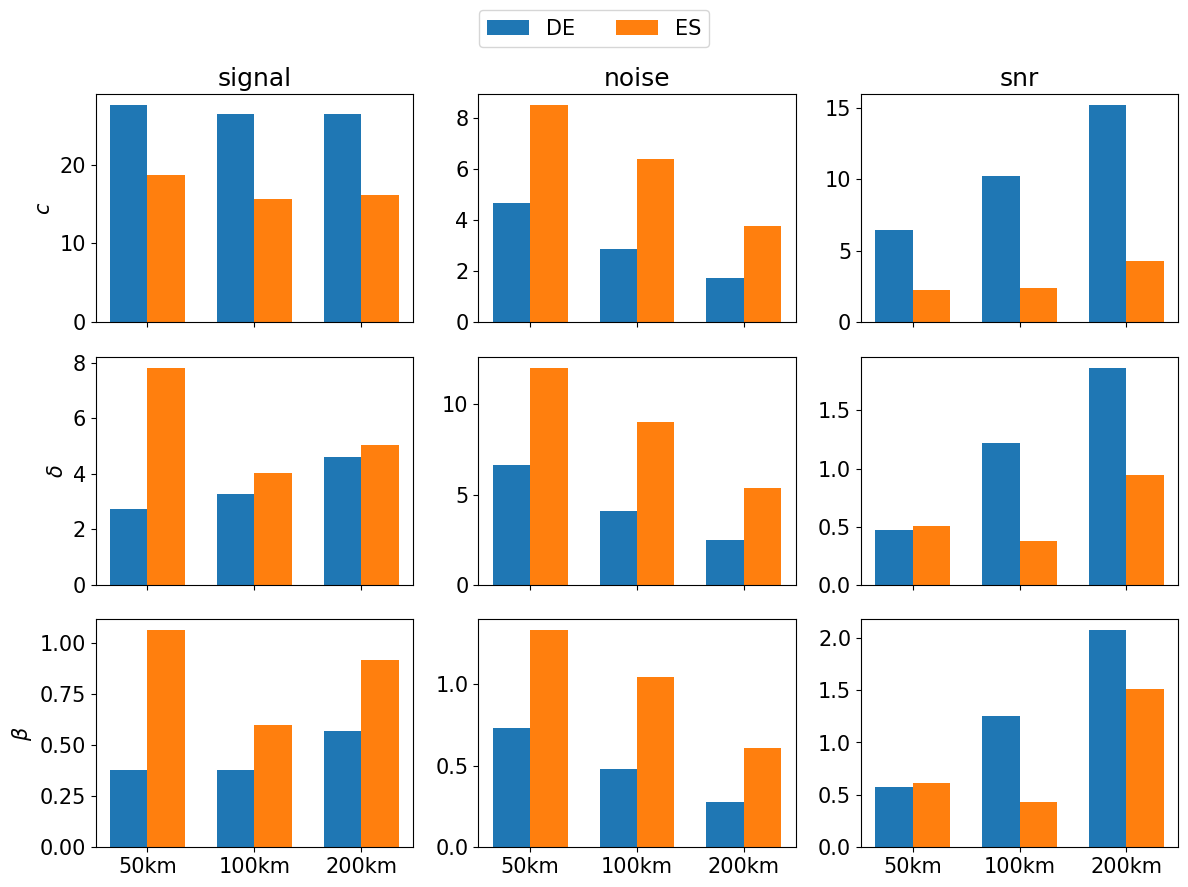

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suppose you already have these dataframes
dataframes = [agg, agp_df, ags_df]
df_labels = ['$c$', '$\delta$', r'$\beta$']
metrics = ['signal', 'noise', 'snr']

# Unique scales and regions
all_scales = sorted(set(agg['scale']) | set(agp_df['scale']) | set(ags_df['scale']))
all_regions = sorted(set(agg['region']) | set(agp_df['region']) | set(ags_df['region']))

region_colors = {region: color for region, color in zip(all_regions, ['tab:blue', 'tab:orange'])}

fig, axes = plt.subplots(3, 3, figsize=(12, 9)) #, sharey='col'
bar_width = 0.35  # Width of bars within a group

for row_idx, (df, df_label) in enumerate(zip(dataframes, df_labels)):
    for col_idx, metric in enumerate(metrics):
        ax = axes[row_idx, col_idx]
        df_sorted = df.sort_values(by='scale')

        # Group by scale
        grouped = df.groupby('scale')

        scales = sorted(df['scale'].unique())
        x = np.arange(len(scales))  # bar group positions

        for i, region in enumerate(all_regions):
            values = []
            for scale in scales:
                subset = df[(df['scale'] == scale) & (df['region'] == region)][metric]
                if not subset.empty:
                    values.append(subset.mean())
                else:
                    values.append(0)  # or np.nan if you prefer
            offset = (i - 0.5) * bar_width  # Adjust position for regions
            ax.bar(x + offset, values, width=bar_width, label=region if row_idx == 0 else "", color=region_colors[region])

        if row_idx ==0:
            ax.set_title(f'{metric}')
        else:
            ax.set_title('')
        ax.set_xticks(x)
        if row_idx == 2:
            ax.set_xticklabels(['50km','100km','200km'])
        else:
            ax.set_xticklabels([])

        if col_idx == 0:
            ax.set_ylabel(df_label)

# Add legend to the top
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(all_regions))

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f'./figure/plot_agg_compare.pdf', bbox_inches='tight')
plt.show()


In [17]:
ags_df

,scale,polygon_id,region,ndvi_mean_y_mean,ndwi_mean_y_mean,time_series,soc_mean_x_series,soc_mean_y_series,soc_std_x_series,soc_std_y_series,$\beta$,$\beta$_intercept,$\beta$_score,$\beta$_std,noise,signal,snr
0,50,47,ES,0.251184,114.707848,"[2009, 2015, 2018]","[12.447058823529412, 10.58064516129032, 11.812...","[10.955573640573885, 10.886692475451477, 11.64...","[5.694773536568295, 4.8018343269240145, 5.1416...","[4.693995875260735, 4.74998088402761, 4.739551...",-0.156912,12.381647,0.192558,0.856237,0.856237,0.156912,0.183258
1,50,94,ES,0.447669,126.234383,"[2009, 2015, 2018]","[16.183333333333334, 23.3, 37.77777777777778]","[28.747198565625972, 28.767889504974644, 27.94...","[9.131794274219425, 12.784574038008985, 31.659...","[12.338964239530224, 12.32054544501344, 12.219...",1.972294,15.856301,0.848155,2.125659,2.125659,1.972294,0.927851
2,50,577,DE,0.680099,153.423477,"[2009, 2015, 2018]","[31.50625, 27.57, 28.95]","[28.118623110240467, 29.651161033583683, 31.88...","[28.833879811776974, 15.538057221616292, 17.60...","[5.8269774176132385, 6.204295303547166, 6.7413...",-0.416810,31.405388,0.564971,0.946989,0.946989,0.416810,0.440142
3,50,580,DE,0.596011,145.929214,"[2009, 2015, 2018]","[23.84, 28.146153846153844, 25.1]","[21.2437412830644, 22.32491662991244, 22.19192...","[11.33829163246638, 14.370955395322852, 5.6568...","[3.0658036329855496, 3.241045085071509, 3.0349...",0.344385,23.996051,0.148378,0.485447,0.485447,0.344385,0.709419
4,100,12,ES,0.289606,115.138283,"[2009, 2015, 2018]","[10.330337078651684, 9.52361111111111, 10.9086...","[13.040473610384813, 12.357147198655737, 14.49...","[5.807056923464721, 4.467487968427427, 5.83018...","[4.673442537647828, 4.709902903683954, 4.85961...",-0.007769,10.276123,-0.027692,0.677480,0.677480,0.007769,0.011467
5,100,23,ES,0.398207,120.573914,"[2009, 2015, 2018]","[15.009333333333334, 22.263846153846156, 25.66...","[24.061048752815832, 23.70587929777756, 23.104...","[10.596164187832102, 16.38971602237139, 20.299...","[8.217933038793218, 7.988995058765033, 7.90238...",1.193747,15.016564,0.999726,1.170138,1.170138,1.193747,1.020177
6,100,145,DE,0.667116,152.649353,"[2009, 2015, 2018]","[29.791666666666668, 28.97297297297297, 29.084...","[31.395455622495852, 32.84822806112324, 34.914...","[19.564631933543637, 15.50336251428216, 13.705...","[3.7511525575827838, 3.903926902289485, 4.1959...",-0.100558,29.775494,0.782908,0.597388,0.597388,0.100558,0.168330
7,100,146,DE,0.610646,147.434006,"[2009, 2015, 2018]","[20.43684210526316, 20.68653846153846, 29.3800...","[21.199602758808638, 22.402612617027028, 22.51...","[12.327041001376775, 12.858125207869026, 18.58...","[1.7473538477239785, 1.8426439906372403, 1.804...",0.658543,20.180216,0.563447,0.283644,0.283644,0.658543,2.321726
8,200,282,ES,0.349815,118.670891,"[2009, 2015, 2018]","[11.516040955631398, 17.83123425692695, 19.071...","[17.638531093323124, 17.19446018733985, 17.825...","[7.515033929212893, 15.840648445367776, 18.225...","[3.82710545186982, 3.777974288027636, 3.726293...",0.916747,11.574150,0.965202,0.518675,0.518675,0.916747,1.767478
9,200,421,DE,0.643213,151.547867,"[2009, 2015, 2018]","[23.719576719576718, 24.948076923076925, 30.64...","[27.720217865475064, 29.130790666588744, 30.20...","[14.151380950232529, 13.95547514778684, 15.208...","[1.6734578223359897, 1.7340169902695473, 1.802...",0.569535,23.567088,0.707892,0.286011,0.286011,0.569535,1.991302
